## Machine Learning: bikeshare data for Capstone 1

Let's start by adding the rest of 2016 data.

As a reminder, the data can be found here, https://s3.amazonaws.com/capitalbikeshare-data/index.html.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

Q1 = pd.read_csv('../CapstoneDrafts/data/2016Q1-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])
Q2 = pd.read_csv('../CapstoneDrafts/data/2016Q2-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])
Q3 = pd.read_csv('../CapstoneDrafts/data/2016Q3-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])
Q4 = pd.read_csv('../CapstoneDrafts/data/2016Q4-capitalbikeshare-tripdata.csv', 
                        parse_dates=True, index_col=1, header=0,
                        names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype'])

In [3]:
bike2016 = Q1.append([Q2,Q3,Q4])
bike2016.duration = bike2016.duration % 60
print('Number of rows in the dataset for 2016:',len(bike2016))
bike2016.head()

Number of rows in the dataset for 2016: 3333994


duration              enddate  startlocID  \
2016-01-01 00:06:58        46  2016-01-01 00:09:44       31102   
2016-01-01 00:10:20        28  2016-01-01 00:17:48       32039   
2016-01-01 00:13:52        55  2016-01-01 00:25:48       31222   
2016-01-01 00:15:29        33  2016-01-01 00:19:03       31506   
2016-01-01 00:16:16        32  2016-01-01 00:30:49       31041   

                                             startloc  endlocID  \
2016-01-01 00:06:58               11th & Kenyon St NW     31105   
2016-01-01 00:10:20  Old Georgetown Rd & Southwick St     32002   
2016-01-01 00:13:52         New York Ave & 15th St NW     31214   
2016-01-01 00:15:29         1st & Rhode Island Ave NW     31509   
2016-01-01 00:16:16              Prince St & Union St     31048   

                                          endloc  bikeID memtype  
2016-01-01 00:06:58         14th & Harvard St NW  W01346  Member  
2016-01-01 00:10:20  Bethesda Ave & Arlington Rd  W22202  Member  
2016-01-01 00:13:52        17th & Corcoran St NW  W21427  Member  
2016-01-01 00:15:29     New Jersey Ave & R St NW  W01294  Member  
2016-01-01 00:16:16          King St Metro South  W22058  Member

Text(0,0.5,'Rental Duration (m)')

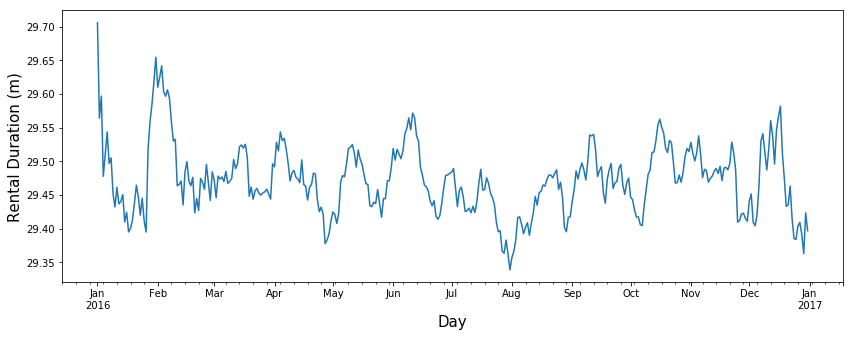

In [4]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14,5)
duration = bike2016['duration']
smoothed = duration.resample('D').mean().rolling(window=12, min_periods=1).mean()
smoothed.plot(ax=ax)
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Rental Duration (m)',fontsize=15)

Are there different durations for registered versus casual members?

In [5]:
durationReg = bike2016['duration'][bike2016['memtype']=='Member']
durationCas = bike2016['duration'][bike2016['memtype']=='Casual']

smoothedReg = durationReg.resample('D').mean().rolling(window=12, min_periods=1).mean()
smoothedCas = durationCas.resample('D').mean().rolling(window=12, min_periods=1).mean()

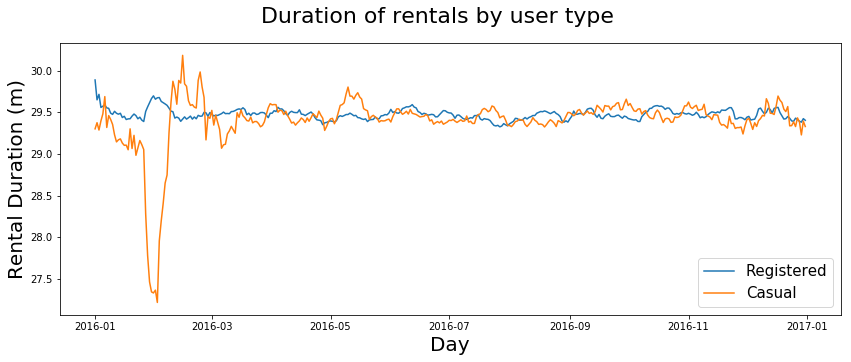

In [6]:
fig, ax = plt.subplots(1)
fig.set_size_inches(14,5)
ax.plot(smoothedReg, label='Registered')
ax.plot(smoothedCas, label='Casual')
ax.set_xlabel('Day',fontsize=20)
ax.set_ylabel('Rental Duration (m)',fontsize=20)
fig.suptitle('Duration of rentals by user type', fontsize=22)
ax.legend(fontsize=15)
#plt.savefig('bike_rolling_type',bbox_inches='tight',dpi=300)

In [7]:
bike2016['startdate'] = bike2016.index
bike2016['startweekday'] = bike2016['startdate'].apply(lambda d: d.weekday())

Text(0.5,0,'Day of the Week')

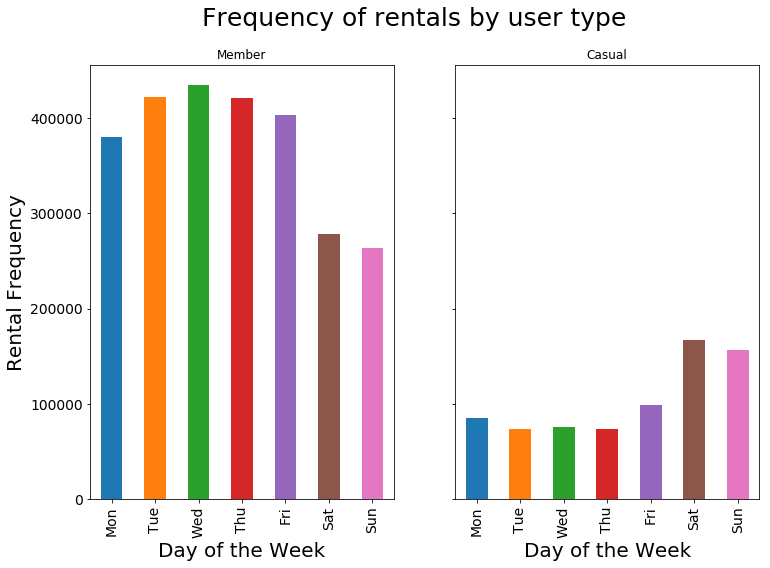

In [10]:
FreqReg=bike2016['startweekday'][bike2016['memtype']=='Member'].value_counts().sort_index()
FreqCas=bike2016['startweekday'][bike2016['memtype']=='Casual'].value_counts().sort_index()
ticks=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'] 
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(12,8)
FreqReg.plot(kind='bar', ax=axes[0],title='Member',fontsize=14)
FreqCas.plot(kind='bar', ax=axes[1],title='Casual',fontsize=14)
axes[0].set_xticklabels(ticks)
axes[1].set_xticklabels(ticks)
fig.suptitle('Frequency of rentals by user type', fontsize=25)
axes[0].set_xlabel('Day of the Week',fontsize=20)
axes[0].set_ylabel('Rental Frequency',fontsize=20)
axes[1].set_xlabel('Day of the Week',fontsize=20)
#plt.savefig('bike_histo_type',bbox='tight',dpi=300)

## Analysis Steps

- Predict demand (# of rentals) on a given day (e.g. for 2017) 
    - linear regression/SVM
    - X: julian day; y: count/day
    - could add X: daily max temp, daily min temp, proximity to metro station
- Predict demand on a given day by station ID
    - linear regression/SVM
    - X: julian day, staion ID; y: count/day/station
    - coul add X: daily max temp, daily min temp, proximity to metro station


In [11]:
#find metro station info (euclidian distance... find lat/long of metro stations)
import json
from pandas.io.json import json_normalize

json_data=open('../CapstoneDrafts/data/stations2.json').read()
metro=pd.read_json(json_data, orient='records')
MetroDF = json_normalize(data=metro['Stations'])

print('Number of stations:',len(MetroDF))
MetroDF.head()

Number of stations: 95


Address.City Address.State              Address.Street Address.Zip Code  \
0   Washington            DC             607 13th St. NW       20005  A01   
1   Washington            DC  1001 Connecticut Avenue NW       20036  A02   
2   Washington            DC            1525 20th St. NW       20036  A03   
3   Washington            DC   2700 Connecticut Ave., NW       20008  A04   
4   Washington            DC  3599 Connecticut Avenue NW       20008  A05   

         Lat LineCode1 LineCode2 LineCode3 LineCode4        Lon  \
0  38.898303        RD      None      None      None -77.028099   
1  38.903192        RD      None      None      None -77.039766   
2  38.909499        RD      None      None      None -77.043620   
3  38.924999        RD      None      None      None -77.052648   
4  38.934703        RD      None      None      None -77.058226   

                            Name StationTogether1 StationTogether2  
0                   Metro Center              C01                   
1                 Farragut North                                    
2                  Dupont Circle                                    
3  Woodley Park-Zoo/Adams Morgan                                    
4                 Cleveland Park

In [12]:
# find and add weather data (daily max & min)
weather = pd.read_csv('../CapstoneDrafts/data/dc_weather.csv', parse_dates=True, index_col=2, header=0,
                        names=['station','name','startdate','tmax','tmin'])
weather.head()

station                          name  tmax  tmin
startdate                                                        
2016-01-01  USC00186350  NATIONAL ARBORETUM DC, MD US  56.0  41.0
2016-01-02  USC00186350  NATIONAL ARBORETUM DC, MD US  46.0  31.0
2016-01-03  USC00186350  NATIONAL ARBORETUM DC, MD US  48.0  29.0
2016-01-04  USC00186350  NATIONAL ARBORETUM DC, MD US  53.0  29.0
2016-01-05  USC00186350  NATIONAL ARBORETUM DC, MD US  38.0  15.0

In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7186 entries, 2016-01-01 to NaT
Data columns (total 4 columns):
station    726 non-null object
name       726 non-null object
tmax       726 non-null float64
tmin       724 non-null float64
dtypes: float64(2), object(2)
memory usage: 280.7+ KB


In [14]:
#add time tracking column (days from 2016-01-01), break dates into month and day
from datetime import datetime as dt
starttime = dt.strptime('2016-01-01', '%Y-%m-%d')
bike2016['timeDelt'] = bike2016['startdate'].apply(lambda d: (d - starttime).days)

In [15]:
bike2016.tail()

duration              enddate  startlocID  \
2016-12-31 23:49:54        14  2017-01-01 00:00:09       31118   
2016-12-31 23:51:58         3  2017-01-01 00:00:01       31612   
2016-12-31 23:52:59        18  2017-01-01 00:00:18       31603   
2016-12-31 23:53:53        59  2017-01-01 00:13:53       31249   
2016-12-31 23:54:20        44  2017-01-01 00:08:05       31232   

                                                      startloc  endlocID  \
2016-12-31 23:49:54                            3rd & Elm St NW     31102   
2016-12-31 23:51:58                     D St & Maryland Ave NE     31628   
2016-12-31 23:52:59                              1st & M St NE     31506   
2016-12-31 23:53:53                         Jefferson Memorial     31003   
2016-12-31 23:54:20  7th & F St NW / National Portrait Gallery     31290   

                                            endloc  bikeID memtype  \
2016-12-31 23:49:54            11th & Kenyon St NW  W20961  Member   
2016-12-31 23:51:58                  1st & K St SE  W00381  Member   
2016-12-31 23:52:59      1st & Rhode Island Ave NW  W00246  Casual   
2016-12-31 23:53:53              15th & Crystal Dr  W23100  Member   
2016-12-31 23:54:20  17th St & Independence Ave SW  W01135  Member   

                              startdate  startweekday  timeDelt  
2016-12-31 23:49:54 2016-12-31 23:49:54             5       365  
2016-12-31 23:51:58 2016-12-31 23:51:58             5       365  
2016-12-31 23:52:59 2016-12-31 23:52:59             5       365  
2016-12-31 23:53:53 2016-12-31 23:53:53             5       365  
2016-12-31 23:54:20 2016-12-31 23:54:20             5       365

In [16]:
bike2016['Year'] = bike2016['startdate'].apply(lambda t: t.year)
bike2016['Month'] = bike2016['startdate'].apply(lambda t: t.month)
bike2016['Day'] = bike2016['startdate'].apply(lambda t: t.day)

In [17]:
bike2016.head()

duration              enddate  startlocID  \
2016-01-01 00:06:58        46  2016-01-01 00:09:44       31102   
2016-01-01 00:10:20        28  2016-01-01 00:17:48       32039   
2016-01-01 00:13:52        55  2016-01-01 00:25:48       31222   
2016-01-01 00:15:29        33  2016-01-01 00:19:03       31506   
2016-01-01 00:16:16        32  2016-01-01 00:30:49       31041   

                                             startloc  endlocID  \
2016-01-01 00:06:58               11th & Kenyon St NW     31105   
2016-01-01 00:10:20  Old Georgetown Rd & Southwick St     32002   
2016-01-01 00:13:52         New York Ave & 15th St NW     31214   
2016-01-01 00:15:29         1st & Rhode Island Ave NW     31509   
2016-01-01 00:16:16              Prince St & Union St     31048   

                                          endloc  bikeID memtype  \
2016-01-01 00:06:58         14th & Harvard St NW  W01346  Member   
2016-01-01 00:10:20  Bethesda Ave & Arlington Rd  W22202  Member   
2016-01-01 00:13:52        17th & Corcoran St NW  W21427  Member   
2016-01-01 00:15:29     New Jersey Ave & R St NW  W01294  Member   
2016-01-01 00:16:16          King St Metro South  W22058  Member   

                              startdate  startweekday  timeDelt  Year  Month  \
2016-01-01 00:06:58 2016-01-01 00:06:58             4         0  2016      1   
2016-01-01 00:10:20 2016-01-01 00:10:20             4         0  2016      1   
2016-01-01 00:13:52 2016-01-01 00:13:52             4         0  2016      1   
2016-01-01 00:15:29 2016-01-01 00:15:29             4         0  2016      1   
2016-01-01 00:16:16 2016-01-01 00:16:16             4         0  2016      1   

                     Day  
2016-01-01 00:06:58    1  
2016-01-01 00:10:20    1  
2016-01-01 00:13:52    1  
2016-01-01 00:15:29    1  
2016-01-01 00:16:16    1

In [ ]:
#count rows per julian day (add count column)

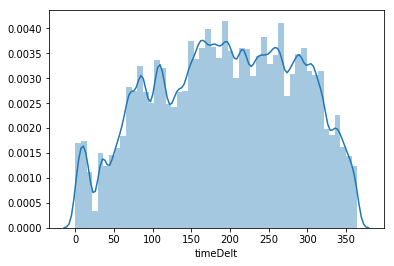

In [18]:
sns.distplot(bike2016['timeDelt'])

In [19]:
grouped = bike2016.groupby('timeDelt')['Year','Month','Day','startdate','timeDelt','startweekday'].max()
grouped['totalRents'] = bike2016.groupby('timeDelt')['timeDelt'].size()
grouped['timeDelt_sq'] = grouped['timeDelt'].apply(lambda s: s**2)
grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 365
Data columns (total 8 columns):
Year            362 non-null int64
Month           362 non-null int64
Day             362 non-null int64
startdate       362 non-null datetime64[ns]
timeDelt        362 non-null int64
startweekday    362 non-null int64
totalRents      362 non-null int64
timeDelt_sq     362 non-null int64
dtypes: datetime64[ns](1), int64(7)
memory usage: 25.5 KB


In [20]:
grouped['startdate'] = grouped['startdate'].apply(lambda s: s.date())

In [21]:
grouped.head()

Year  Month  Day   startdate  timeDelt  startweekday  totalRents  \
timeDelt                                                                     
0         2016      1    1  2016-01-01         0             4        3220   
1         2016      1    2  2016-01-02         1             5        4921   
2         2016      1    3  2016-01-03         2             6        4965   
3         2016      1    4  2016-01-04         3             0        5133   
4         2016      1    5  2016-01-05         4             1        4850   

          timeDelt_sq  
timeDelt               
0                   0  
1                   1  
2                   4  
3                   9  
4                  16

In [22]:
# add holiday indicator
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2016')
grouped = grouped.join(pd.Series(1, index=holidays, name='holiday'))
grouped['holiday'].fillna(0, inplace=True)

In [ ]:
#merge weather data

In [23]:
weather['startdate2'] = weather.index
weather['startdate2'] = weather['startdate2'].apply(lambda s: s.date())
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7186 entries, 2016-01-01 to NaT
Data columns (total 5 columns):
station       726 non-null object
name          726 non-null object
tmax          726 non-null float64
tmin          724 non-null float64
startdate2    726 non-null object
dtypes: float64(2), object(3)
memory usage: 336.8+ KB


In [24]:
grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362 entries, 0 to 365
Data columns (total 9 columns):
Year            362 non-null int64
Month           362 non-null int64
Day             362 non-null int64
startdate       362 non-null object
timeDelt        362 non-null int64
startweekday    362 non-null int64
totalRents      362 non-null int64
timeDelt_sq     362 non-null int64
holiday         362 non-null float64
dtypes: float64(1), int64(7), object(1)
memory usage: 38.3+ KB


In [59]:
grouped2 = pd.merge(grouped, weather, how='left', left_on='startdate', right_on='startdate2')
grouped2.head()

Year  Month  Day   startdate  timeDelt  startweekday  totalRents  \
0  2016      1    1  2016-01-01         0             4        3220   
1  2016      1    2  2016-01-02         1             5        4921   
2  2016      1    3  2016-01-03         2             6        4965   
3  2016      1    4  2016-01-04         3             0        5133   
4  2016      1    5  2016-01-05         4             1        4850   

   timeDelt_sq  holiday      station                          name  tmax  \
0            0      0.0  USC00186350  NATIONAL ARBORETUM DC, MD US  56.0   
1            1      0.0  USC00186350  NATIONAL ARBORETUM DC, MD US  46.0   
2            4      0.0  USC00186350  NATIONAL ARBORETUM DC, MD US  48.0   
3            9      0.0  USC00186350  NATIONAL ARBORETUM DC, MD US  53.0   
4           16      0.0  USC00186350  NATIONAL ARBORETUM DC, MD US  38.0   

   tmin  startdate2  
0  41.0  2016-01-01  
1  31.0  2016-01-02  
2  29.0  2016-01-03  
3  29.0  2016-01-04  
4  15.0  2016-01-05

In [60]:
grouped2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 361
Data columns (total 14 columns):
Year            362 non-null int64
Month           362 non-null int64
Day             362 non-null int64
startdate       362 non-null object
timeDelt        362 non-null int64
startweekday    362 non-null int64
totalRents      362 non-null int64
timeDelt_sq     362 non-null int64
holiday         362 non-null float64
station         361 non-null object
name            361 non-null object
tmax            361 non-null float64
tmin            361 non-null float64
startdate2      361 non-null object
dtypes: float64(3), int64(7), object(4)
memory usage: 42.4+ KB


In [61]:
'''
theres a NaN somewhere, forward fill (because weather is probably non-independent, 
and a forward fill therefore makes sense here, rather than a mean, e.g.)
'''
grouped2=grouped2.fillna(method='ffill')

In [62]:
# convert days of the week (startweekday) to dummy variable columns
weekday_dummies = pd.get_dummies(grouped['startweekday'], prefix='day')
grouped2 = pd.merge(grouped2, weekday_dummies, how='outer', left_index=True, right_index=True)

In [63]:
grouped2.head()

Year  Month  Day   startdate  timeDelt  startweekday  totalRents  \
0  2016.0    1.0  1.0  2016-01-01       0.0           4.0      3220.0   
1  2016.0    1.0  2.0  2016-01-02       1.0           5.0      4921.0   
2  2016.0    1.0  3.0  2016-01-03       2.0           6.0      4965.0   
3  2016.0    1.0  4.0  2016-01-04       3.0           0.0      5133.0   
4  2016.0    1.0  5.0  2016-01-05       4.0           1.0      4850.0   

   timeDelt_sq  holiday      station  ...    tmax  tmin  startdate2 day_0  \
0          0.0      0.0  USC00186350  ...    56.0  41.0  2016-01-01   0.0   
1          1.0      0.0  USC00186350  ...    46.0  31.0  2016-01-02   0.0   
2          4.0      0.0  USC00186350  ...    48.0  29.0  2016-01-03   0.0   
3          9.0      0.0  USC00186350  ...    53.0  29.0  2016-01-04   1.0   
4         16.0      0.0  USC00186350  ...    38.0  15.0  2016-01-05   0.0   

   day_1  day_2  day_3  day_4  day_5  day_6  
0    0.0    0.0    0.0    1.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    1.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    1.0  
3    0.0    0.0    0.0    0.0    0.0    0.0  
4    1.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 21 columns]

In [64]:
grouped2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 21 columns):
Year            362 non-null float64
Month           362 non-null float64
Day             362 non-null float64
startdate       362 non-null object
timeDelt        362 non-null float64
startweekday    362 non-null float64
totalRents      362 non-null float64
timeDelt_sq     362 non-null float64
holiday         362 non-null float64
station         362 non-null object
name            362 non-null object
tmax            362 non-null float64
tmin            362 non-null float64
startdate2      362 non-null object
day_0           362 non-null float64
day_1           362 non-null float64
day_2           362 non-null float64
day_3           362 non-null float64
day_4           362 non-null float64
day_5           362 non-null float64
day_6           362 non-null float64
dtypes: float64(17), object(4)
memory usage: 62.9+ KB


In [ ]:
#count rows per julian day per station id 'startlocID' (add count column)

In [29]:
groupedStart = bike2016.groupby(['startlocID','timeDelt'])[
    'Year','Month','Day','startweekday','timeDelt','startlocID'].max()
groupedStart['totalRents'] = bike2016.groupby(['startlocID','timeDelt'])['startlocID'].size()
groupedStart['timeDelt_sq'] = groupedStart['timeDelt'].apply(lambda s: s**2)

### Build a model

- Predict demand (# of rentals) on a given day (e.g. for 2017) 
    - linear regression/SVM
    - X: julian day; y: count/day
    - could add X: proximity to metro station <-- but is this redundant with station? could use for interpretation

#### Model steps: 
  - split data into train (2016) and test (2017)
  - initialize a model (e.g. linear regression)
  - cross validation

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import math

In [52]:
X1 = grouped[['timeDelt', 'timeDelt_sq']]
y = grouped['totalRents']

In [53]:
lr1 = LinearRegression(normalize=True)
lr1.fit(X1, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [55]:
scores1 = cross_val_score(lr1, X1, y, cv=5, scoring='r2')
print('mean r2:',np.mean(scores1))

mean r2: -0.2263799005187404


In [62]:
# model with daily mininum and maximum temperatures 
X2 = grouped2[['timeDelt', 'timeDelt_sq','tmax', 'tmin']]
y = grouped2['totalRents']

In [63]:
lr2 = LinearRegression(normalize=True)
lr2.fit(X2, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [65]:
scores2 = cross_val_score(lr2, X2, y, cv=5, scoring='r2')
print('mean r2:',np.mean(scores2))

mean r2: -0.08393091446491159


In [65]:
# model with daily mininum and maximum temperatures, weekday dummies, and holiday indicator
X3 = grouped2[['timeDelt', 'timeDelt_sq','tmax', 'tmin','day_0','day_1','day_2','day_3','day_4','day_5','holiday']]
y = grouped2['totalRents']

In [67]:
X3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 11 columns):
timeDelt       362 non-null float64
timeDelt_sq    362 non-null float64
tmax           362 non-null float64
tmin           362 non-null float64
day_0          362 non-null float64
day_1          362 non-null float64
day_2          362 non-null float64
day_3          362 non-null float64
day_4          362 non-null float64
day_5          362 non-null float64
holiday        362 non-null float64
dtypes: float64(11)
memory usage: 34.3 KB


In [66]:
lr3 = LinearRegression(normalize=True)
lr3.fit(X3, y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
scores3 = cross_val_score(lr3, X3, y, cv=5, scoring='r2')
print('mean r2:',np.mean(scores3))

Initial findings: it looks like the simpler model results in a stronger R2.

In [ ]:
#predictions
grouped2['predicted'] = lr3.predict(X3)
grouped2[['Total', 'predicted']].plot(alpha=0.5);

In [ ]:
params = pd.Series(lr3.coef_, index=X3.columns)
params